# 4. Metrics

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2024/03/25*

**Table of contents**

* [4.1. Loading ADI data](#4.1.-Loading-ADI-data)
* [4.2. Signal-to-noise ratio and significance](#4.2.-Signal-to-noise-ratio-and-significance)
    - [4.2.1. S/N map](#4.2.1.-S/N-map)
    - [4.2.2. Significance](#4.2.2.-Significance)
    - [4.2.3. STIM map](#4.2.3.-STIM-map)
* [4.3. Automatic detection function](#4.3.-Automatic-detection-function)
* [4.4. Throughput and contrast curves](#4.4.-Throughput-and-contrast-curves)
    - [4.4.1. Throughput](#4.4.1.-Throughput)
    - [4.4.2. Contrast curves](#4.4.2.-Contrast-curves)
* [4.5. Completeness curves and maps](#4.5.-Completeness-curves-and-maps)
    - [4.5.1. Completeness curves](#4.5.1.-Completeness-curves)
    - [4.5.2. Completeness maps](#4.5.2.-Conpleteness-maps)
* [4.6. Applefy contrast curves and grids](#4.6.-Applefy-contrast-curves-and-grids)
    - [4.6.1. Applefy contrast curves](#4.6.1.-Applefy-contrast-curves)
    - [4.6.2. Applefy contrast grids](#4.6.2.-Applefy-contrast-grids)
        - [4.6.2.1. Visualizing the contrast grids](#4.6.2.1.-Visualizing-the-contrast-grids)
        - [4.6.2.2. Visualizing the thresholded contrast curves](#4.6.2.2.-Visualizing-the-thresholded-contrast-curves)    

This tutorial shows:

- how to compute the S/N ratio of a given companion candidate;
- how to calculate the significance of a detection;
- how to compute S/N ratio maps and STIM maps; 
- how to use the automatic point-source detection function;
- how to compute throughput and contrast curves;
- how to compute robust contrast curves and contrast grids with Applefy (**requires the installation of `Applefy`** -- details [here](https://applefy.readthedocs.io/en/latest/index.html#)).

-----------

**Disclaimer on multi-processing**

A number of routines in the `metrics` subpackage have been implemented for compatibility with multiprocessing, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call (or which internally calls a `psfsub` function, such as the contrast curve function) can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters **BEFORE** launching your Jupyter notebook:

export MKL_NUM_THREADS=1

export NUMEXPR_NUM_THREADS=1

export OMP_NUM_THREADS=1

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from multiprocessing import cpu_count
import numpy as np
import os
from packaging import version
from scipy import interpolate

# Seaborn is only necessary to plot Applefy contrast grid results.
# It is not a mandatory requirement of VIP (only one cell will not compile in this notebook).
try:
    import seaborn as sns
    no_sns=False
except:
    no_sns=True

In the following box we check that your version of VIP passes the requirements to run this notebook:

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) <= version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be striclty above 1.0.3 to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.0


## 4.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
from vip_hci.fits import open_fits

psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
angs = open_fits(angname)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

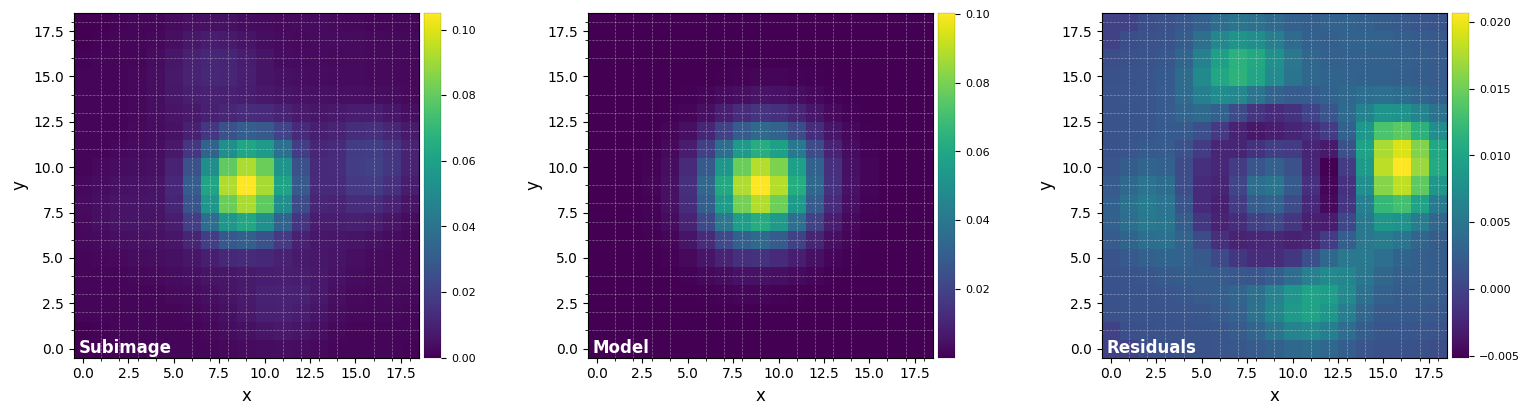

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [5]:
print(fwhm_naco)

4.800919383981533


Let's visualize the flux-normalized PSF:

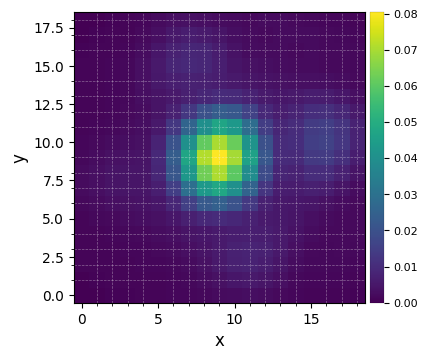

In [6]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [7]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 4.2. Signal-to-noise ratio and significance

### 4.2.1. S/N map

When testing different stellar PSF modeling and subtraction algorithms, one may end up with a point-like source in the final post-processing images. How can its signal-to-noise ratio be assessed? 

By default we adopt the definition of S/N given in [Mawet el al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract), which uses a two samples t-test for the problem of planet detection. Student (*t*) statistics are relevant for hypothesis testing in presence of a small sample, which is the case of high contrast imaging of point sources at small angles. Since the structure of speckle noise varies radially, only a limited sample of pixels, and independent apertures encompassing them, is available for noise estimation at each radius.

The main idea is to test the flux of a given speckle or planet candidate against the flux measured in independent apertures (resolution elements) at the same radial separation from the center:

$$S/N≡ \frac{\overline{x}_1 - \overline{x}_2}{s_2\sqrt{1+\frac{1}{n_2}}},$$

where $\overline{x}_1$ is the flux of the tested resolution element (blue dot in the figure below), $\overline{x}_2$ and $s_2$ are the mean and empirical standard deviation of the fluxes of the noise resolution elements (red dots in the figure below) and $n_2$ the number of such noise resolution elements.

Let's illustrate this process on a PCA post-processed image which contains a companion candidate:

In [8]:
from vip_hci.psfsub import pca
pca_img = pca(cube, angs, ncomp=6, verbose=False, imlib='vip-fft', interpolation=None)

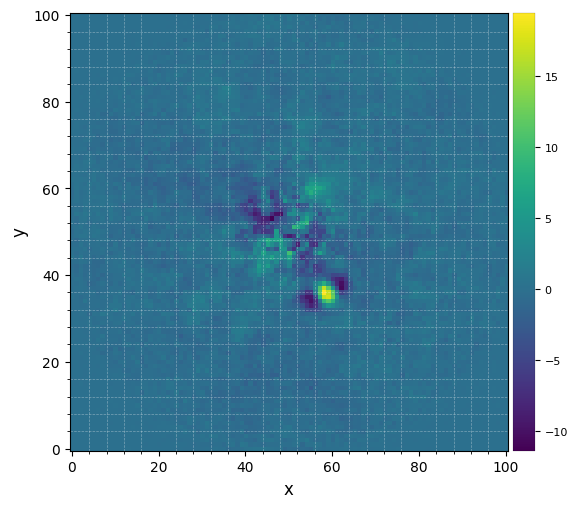

In [9]:
%matplotlib inline
plot_frames(pca_img, grid=True)

Let's define the coordinates of a test point source in the image:

In [10]:
xy_b = (58.8,35.3)

The `snr` function in the `metrics` module can be used to estimate the S/N ratio of the point source:

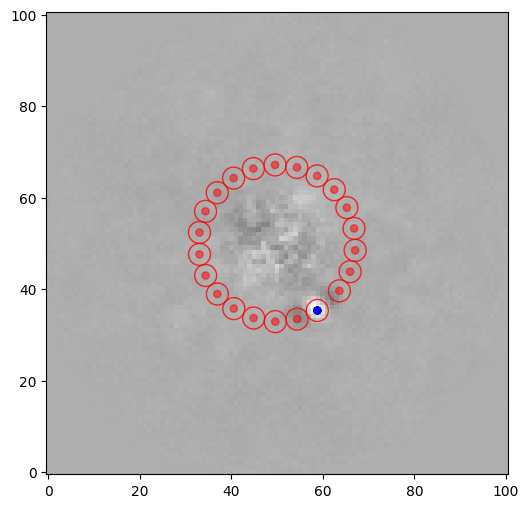

7.193723081700503

In [11]:
from vip_hci.metrics import snr
snr1 = snr(pca_img, source_xy=xy_b, fwhm=fwhm_naco, plot=True)
snr1

The S/N is relatively high, however we see that two of the test apertures are overlapping with the two negative side lobes (which is the typical signature for a point-source imaged with ADI). The `exclude_negative_lobes` option can be set to avoid considering apertures right next to the test aperture, which can make a significant difference in terms of S/N ratio in some cases:

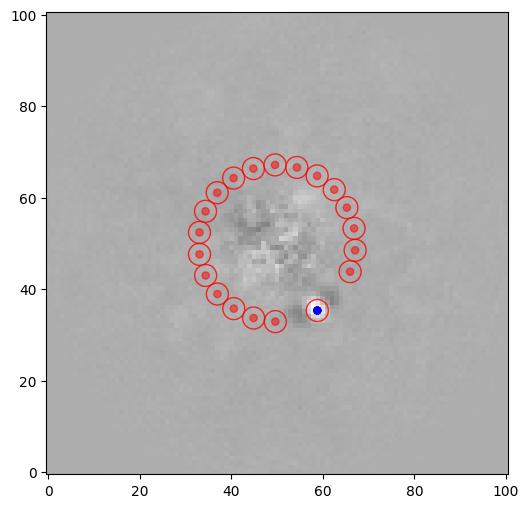

14.27577030847377

In [12]:
snr1 = snr(pca_img, source_xy=xy_b, fwhm=fwhm_naco, plot=True, exclude_negative_lobes=True)
snr1

One has to be careful with the `exclude_negative_lobes` option though, as it decreases the number of test apertures, hence increases the small-angle penalty factor.

In the ``metrics`` subpackage we have also implemented a function for S/N map generation, by computing the S/N for each pixel of a 2D array. It has a parameter `nproc` for exploiting multi-CPU systems which by default is *None*, meaning that it will use half the number of available CPUs in the system.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:47:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


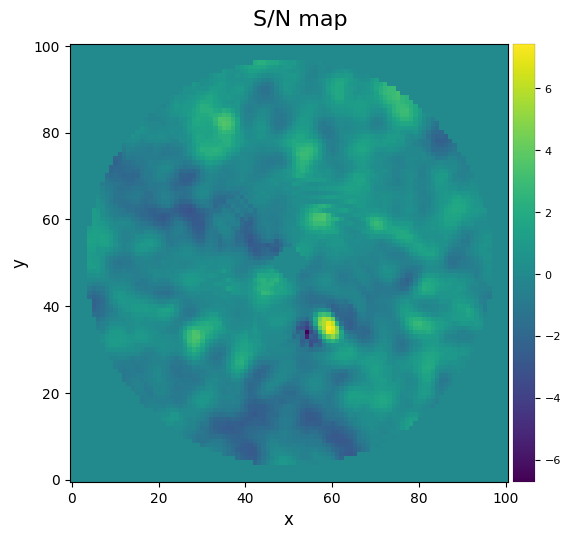

S/N map created using 5 processes
Running time:  0:00:02.635920
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [13]:
from vip_hci.metrics import snrmap
snrmap_1 = snrmap(pca_img, fwhm=fwhm_naco, plot=True, nproc=None)

In case we really need the S/N map of a big frame (which can take quite some time to compute depending on your hardware), a good option is to use the `approximated=True` option. It uses an approximated S/N definition that yields close results to the one mentioned earlier. 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:47:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


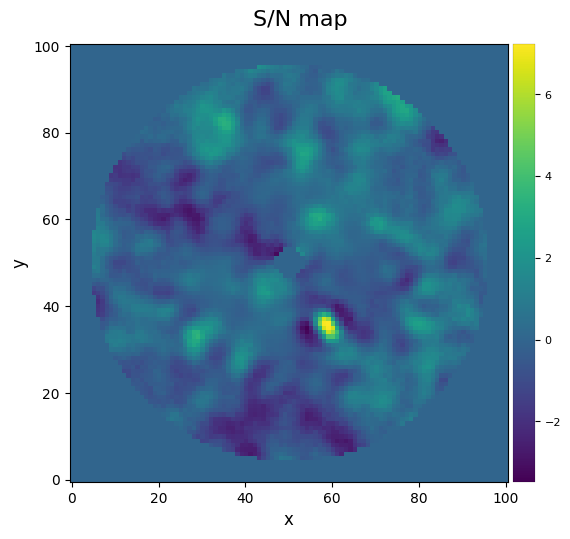

S/N map created using 5 processes
Running time:  0:00:00.223562
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [14]:
snrmap_f = snrmap(pca_img, fwhm=fwhm_naco, plot=True, approximated=True)

<font color=orange> **Question 4.1**: In the presence of azimuthally extended disc signals in the field of view, how do you expect the S/N ratio of authentic sources to behave? Would the classical definition above still be reliable, or would it underestimate/overestimate the true S/N ratio of authentic circumstellar signals? </font>

### 4.2.2. Significance

Due to the common confusion between S/N ratio and significance, we have included a routine to convert (Student) S/N ratio (as defined above) into a Gaussian "sigma" significance, which is the most common metrics used to assess significance in signal detection theory.

The conversion is based on matching the false positive fraction (FPF; e.g. $3 \times 10^{-7}$ for a $5\sigma$ detection threshold), or equivalently the confidence level CL = 1-FPF.

As an example, let's consider a second tentative source (arguably point-like) in our Beta Pic dataset:

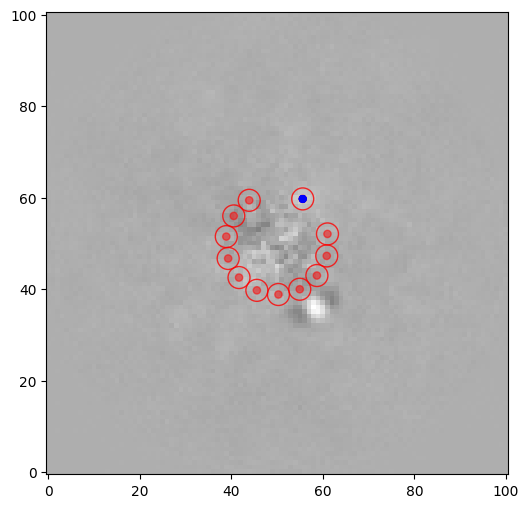

3.067524998435319


In [15]:
xy_test = (55.6, 59.7)
snr2 = snr(pca_img, source_xy=xy_test, fwhm=fwhm_naco, plot=True, exclude_negative_lobes=True)
print(snr2)

The first point source (as shown in Sec. 4.2.1.) has a very high S/N of ~13.8.
The second point-like source has a S/N ~3.1.
What is the significance level that each blob is an authentic point source detection (i.e. not a residual speckle emerging randomly as part of the residual intensity distribution)?

The ``significance`` routine in the `metrics` module takes into account both the S/N ratio and the radial separation of the point source (the FWHM is also required to express that radial separation in terms of FWHM), for conversion to significance in terms of Gaussian statistics.

In [16]:
from vip_hci.metrics import significance
from vip_hci.var import frame_center
cy, cx = frame_center(cube[0])
rad1 = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)
rad2 = np.sqrt((cy-xy_test[1])**2+(cx-xy_test[0])**2)
sig1 = significance(snr1, rad1, fwhm_naco, student_to_gauss=True)
sig2 = significance(snr2, rad2, fwhm_naco, student_to_gauss=True)
msg = "The point-like signal with S/N={:.1f} at r = {:.1f}px ({:.1f} FWHM radius) corresponds to a {:.1f}-sigma detection (Gaussian statistics)."
print(msg.format(snr1, rad1, rad1/fwhm_naco, sig1))
print(msg.format(snr2, rad2, rad2/fwhm_naco, sig2))

At a separation of 17.1 px (3.6 FWHM), S/N = 14.3 corresponds to a 6.9-sigma detection in terms of Gaussian false alarm probability.
At a separation of 11.2 px (2.3 FWHM), S/N = 3.1 corresponds to a 2.6-sigma detection in terms of Gaussian false alarm probability.
The point-like signal with S/N=14.3 at r = 17.1px (3.6 FWHM radius) corresponds to a 6.9-sigma detection (Gaussian statistics).
The point-like signal with S/N=3.1 at r = 11.2px (2.3 FWHM radius) corresponds to a 2.6-sigma detection (Gaussian statistics).


The first point-like signal appears to be an authentic circumstellar point source (i.e. a physical companion or background object) given that its confidence level is equivalent to that of a $6.9\sigma$ detection (Gaussian sigma). For the second blob, the confidence level is equivalent to that of a $2.7\sigma$ detection (Gaussian statistics) - i.e. it is not a significant detection considering common conventions (3-sigma or 5-sigma threhold).

<font color=orange>**Question 4.2**: How can one disentangle a physically bound companion (planet, brown dwarf of stellar binary) from a background object?</font>

### 4.2.3. STIM map

In the presence of extended disc signals, an alternative to the S/N map is to use the Standardized Trajectory Intensity Map (STIM; [Pairet et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.487.2262P/abstract)). A comparison between S/N and STIM maps for disc signals in the system of PDS 70 can be found in [Christiaens et al. (2019a)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.5819C/abstract).

The STIM map is defined by:

$${\rm STIM}(x,y) \equiv \frac{\mu_z (x,y)}{\sigma_z (x,y)},$$

where $\mu_z$ and $\sigma_z$ are the temporal mean and standard deviation of the *derotated residual cube* across the temporal dimension, respectively. It is calculated for each pixel (x,y).

Let's calculate it for our Beta Pictoris L'-band test dataset. For that, let's first run PCA with `full_output=True` to also return the residual cube and derotated residual cube:

In [17]:
from vip_hci.metrics import stim_map
pca_img, _,_, pca_res, pca_res_der = pca(cube, angs, ncomp=15, verbose=False, full_output=True,
                                         imlib='skimage', interpolation='biquartic')

stim_map = stim_map(pca_res_der)

In order to assess which signals are significant in the STIM map, Pairet et al. (2019) recommend to normalize the STIM map with the maximum intensity found in the inverse STIM map, which is obtained in a same way as the STIM map but using opposite angles for the derotation of the residual cube. Starting from VIP v1.6.0, this can be done with function `normalized_stim_map`. For previous versions, this involves the use of `inverse_stim_map`:

In [18]:
from vip_hci.metrics import inverse_stim_map
inv_stim_map = inverse_stim_map(pca_res, angs)

if version.parse(vvip) < version.parse("1.6.0"): 
    norm_stim_map = stim_map/np.nanmax(inv_stim_map)
else:
    from vip_hci.metrics import normalized_stim_map
    norm_stim_map = normalized_stim_map(pca_res, angs)

Using the exact opposite values of derotation angles leads to a similar structure for the residual speckle noise, while authentic signals are not expected to sum up constructively. Therefore the maximum value in the inverse STIM map gives a good estimate of the maximum STIM intensity that one would expect from noise alone.

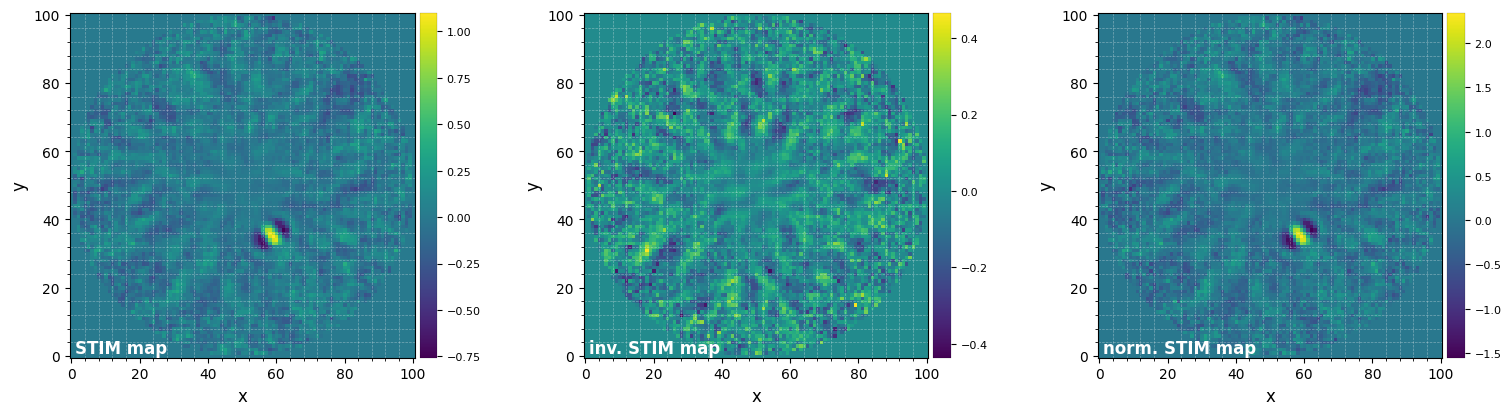

In [19]:
plot_frames((stim_map, inv_stim_map, norm_stim_map), grid=True, 
            label=('STIM map', 'inv. STIM map', 'norm. STIM map'))

Any value larger than unity in the normalized STIM map is therefore expected to be significant. This can be visualized by thresholding the normalized STIM map.

In [20]:
thr_stim_map = norm_stim_map.copy()
thr_stim_map[np.where(thr_stim_map<1)]=0

Beta Pic b is considered significant with the above criterion, although no extended disc structure is detected:

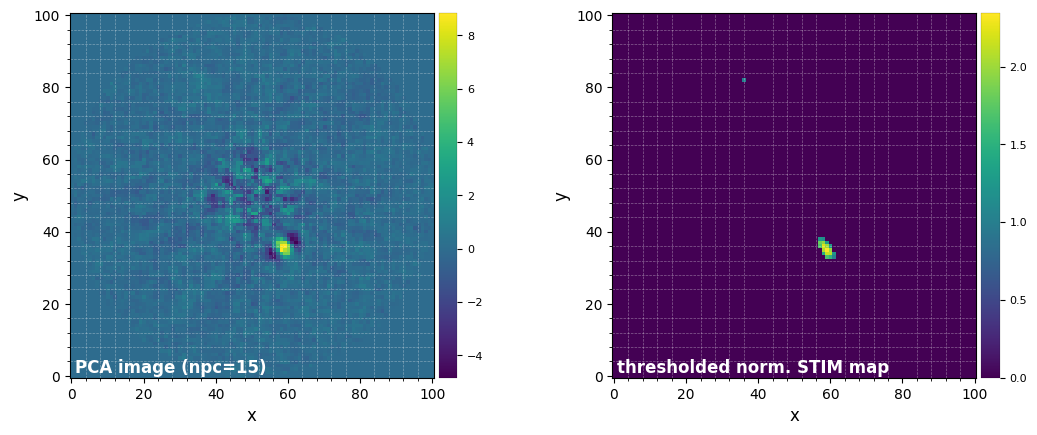

In [21]:
plot_frames((pca_img, thr_stim_map), grid=True, 
            label=('PCA image (npc=15)', 'thresholded norm. STIM map'))

---
**NOTE**

In presence of azimuthally extended disc signals, the above criterion may still be too conservative to capture all disc signals present in the image - as these signals may also show up in the inverse STIM map and even dominate the maximum inverse STIM map values. Differential imaging strategies relying on other sources of *diversity* are required to identify azimuthally extended signals (e.g. RDI, SDI or PDI). 

---

<font color=green> **Answer 4.1:** When test apertures include disc signal, the mean flux $\bar{x}_2$ will be higher and/or the noise level will be overestimated (if the extended signal does not cover all apertures), hence leading in both cases to an underestimated S/N ratio of authentic disc signals. The above definition is therefore only relevant for point source detection.</font> 

<font color=green> **Answer 4.2:** With enough follow-up observations one can monitor the relative astrometry of the companion candidate with respect to the star, and compare it to the proper motion of the star (typically known to good precision thanks to Gaia for nearby stars). A background object (much further away) is expected to have a significantly different (typically much smaller) proper motion than the target. In absence of follow-up observations, a first statistical argument can be made based on the separation of the companion candidate and the number density of background objects in that area of the sky - this can be estimated with `VIP`'s `vip.stats.bkg_star_proba` routine combined with the help of a Galactic model (e.g. TRILEGAL or Besançon model). </font>

## 4.3. Automatic detection function

The `frame_report` routine provides some basic statistics about any post-processed image, including the position and SNR of any candidate in the image. Let's try it on the median-ADI image obtained on our toy dataset:

In [22]:
from vip_hci.psfsub import median_sub
fr_adi = median_sub(cube, angs)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:47:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:01.974664
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [23]:
from vip_hci.metrics import frame_report
frame_report(fr_adi, fwhm=fwhm_naco)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:47:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:02.384149
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of Max px (X,Y) = 55.0, 54.0
Flux in a centered 1xFWHM circular aperture = 470.077
Central pixel S/N = 3.561
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 1.667
Max S/N (shifting the aperture center) = 3.561
stddev S/N (shifting the aperture center) = 1.012
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


((55, 54), [470.07687891671645], [3.5612234828789724], 1.6674225229822748)

Let's try the `detection` function in the `metrics` module. This is a computer vision blob-detection method based on the Laplacian of Gaussian filter (http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log).

Provided a post-processed frame, the FWHM in pixels and a PSF (i.e. what a planet should look like), this function can return the position of point-like sources in the image.
Take a look at the help/docstring for a detailed explanation of the function. Depending on the `mode` the results can be different. A S/N minimum criterion can be provided with `snr_thresh`.

Let's try it on the median-ADI and annular PCA images obtained on the Beta Pic b dataset:

Blobs found: 3
 ycen   xcen
------ ------
46.130 	 43.396
35.555 	 58.654
57.920 	 47.674

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (43.4,46.1)
S/N constraint NOT fulfilled (S/N = 1.626)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (58.7,35.6)
S/N constraint NOT fulfilled (S/N = 2.552)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (47.7,57.9)
S/N constraint NOT fulfilled (S/N = 0.797)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


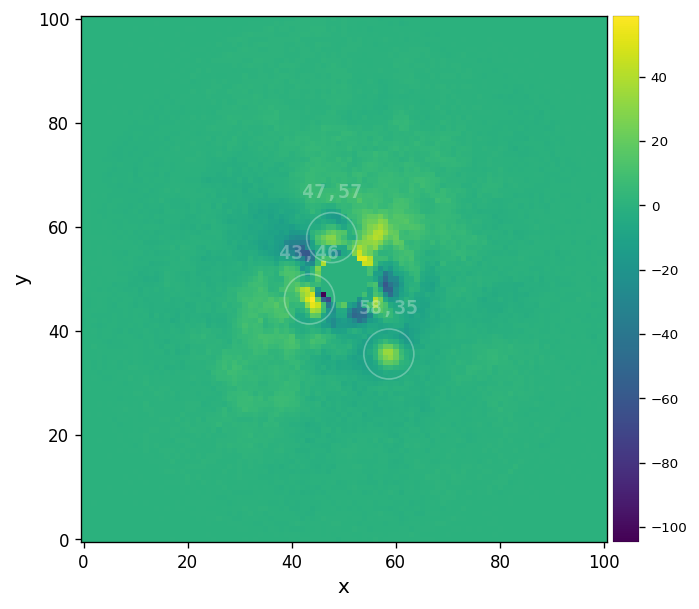

(array([], dtype=float64), array([], dtype=float64))

In [24]:
from vip_hci.metrics import detection
detection(fr_adi, fwhm=fwhm_naco, psf=psfn, debug=False, mode='log', snr_thresh=5, 
          bkg_sigma=5, matched_filter=False)

Planet *b* is highlighted but with rather small S/N (~2). We note that a number of other much less convicing blobs are also highlighted. Let's try the frame obtained with annular PCA:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:47:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 12, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.015969
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  6.94    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.045963
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.04    Ann center:  10    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.083140
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  5.65    Ann center:  14    N segments: 1 
Done PCA with lapack for curr

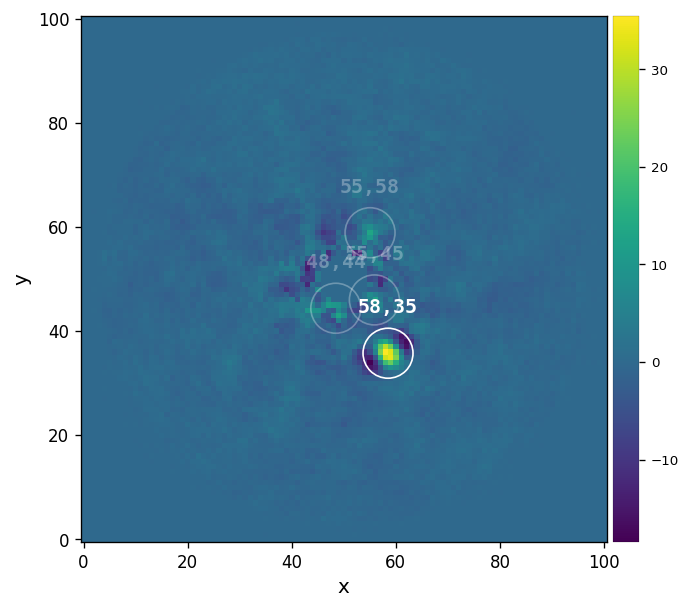

(array([35.70251528]), array([58.49135008]))

In [25]:
from vip_hci.psfsub import pca_annular
fr_pca = pca_annular(cube, angs, ncomp=7)
detection(fr_pca, fwhm=fwhm_naco, psf=psfn, bkg_sigma=5, debug=False, mode='log', 
          snr_thresh=5, plot=True, verbose=True)

We see that only one point-like source stands out above the SNR=5 threshold (set with `snr_thresh`): beta Pic b.

We see from these tests that one should take the results obtained by this automatic detection algorithm with a pinch of salt (see. e.g the signals at the edge of the inner mask). It is unlikely to detect point sources better then can be inferred from visual inspection by human eyes. Much more advanced machine learning techniques should be used to infer the presence of companions that cannot be detected from visual inspection of the final image, and with low false positive fraction (see e.g. [Gomez Gonzalez et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...613A..71G/abstract) or [Cantero et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...680A..86C/abstract)).

## 4.4. Throughput and contrast curves

### 4.4.1. Throughput

`VIP` allows to measure the throughput of its algorithms by injecting fake companions. The throughput gives us an idea of how much the algorithm subtracts or biases the signal from companions, as a function of the distance from the center (high throughput = low amount of self-subtraction). Let's assess it for our toy datacube. The relevant function is `throughput` in the `metrics` module.

In order to measure reliable throughput and contrast curves, one first need to subtract from the data all real companions. 

We'll see in `Tutorial 5.` how to obtain reliable estimates on the parameters of directly imaged companions (radial separation, azimuth and flux). Let's assume we have inferred these parameters. It is only a matter of calling the `cube_planet_free` function in the `fm` module:

In [26]:
from vip_hci.fm import cube_planet_free

r_b =  0.452/pxscale_naco # Absil et al. (2013)
theta_b = 211.2+90 # Absil et al. (2013)
f_b = 648.2

cube_emp = cube_planet_free([(r_b, theta_b, f_b)], cube, angs, psfn=psfn)

---
**NOTE**

The convention in VIP is to measure angles from positive x axis (i.e. as trigonometric angles), as in most other Python packages. This implies adding 90º to position angles measured following the common astronomic convention (East from North).

---

Let's double check the planet was efficiently removed:

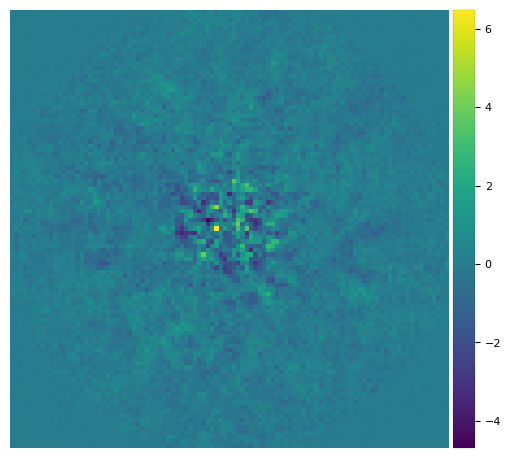

In [27]:
pca_emp = pca(cube_emp, angs, ncomp=12, verbose=False)
plot_frames(pca_emp, axis=False)

Let's now compute the throughput with the empty cube:

In [28]:
from vip_hci.metrics import throughput
res_thr = throughput(cube_emp, angs, psfn, fwhm_naco, ncomp=15, 
                     algo=pca, nbranch=1, full_output=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:48:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube without fake companions processed with pca
Running time:  0:00:01.954914
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Measured annulus-wise noise in resulting frame
Running time:  0:00:01.985581
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Flux in 1xFWHM aperture: 1.000
Fake companions injected in branch 1 (pattern 1/3)
Running time:  0:00:02.075971
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube with fake companions processed with pca
Measuring its annulus-wise throughput
Running time:  0:00:03.970364
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Fake companions injected in branch 1 (pattern 2/3)
Running time:  0:00:04.056175
――――――――――――――――――

Text(0.5, 0, 'separation in pixels')

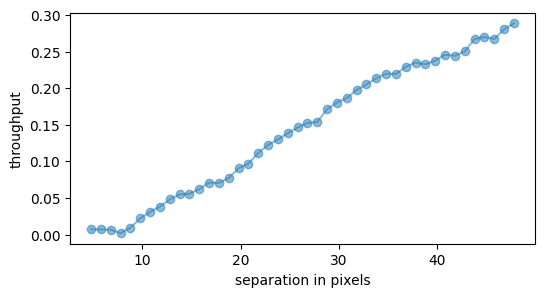

In [30]:
plt.figure(figsize=(6,3))
plt.plot(res_thr[3], res_thr[0][0,:], 'o-', alpha=0.5)   
plt.ylabel('throughput')
plt.xlabel('separation in pixels')

<font color=orange> **Question 4.3**: Why does the throughput increase with radial separation?</font>

Let's compare this with the annular PCA result:

In [31]:
res_thr2 = throughput(cube_emp, angs, psfn, fwhm_naco, algo=pca_annular, nbranch=1, verbose=False,
                      full_output=True, ncomp=10, radius_int=int(fwhm_naco), 
                      delta_rot=1, asize=6)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:56:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:56:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


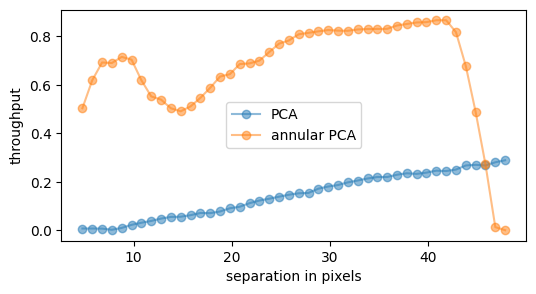

In [32]:
plt.figure(figsize=(6,3))
plt.plot(res_thr[3], res_thr[0][0,:], 'o-', label='PCA', alpha=0.5)
plt.plot(res_thr2[3], res_thr2[0][0,:], 'o-', label='annular PCA', alpha=0.5)
plt.ylabel('throughput')
plt.xlabel('separation in pixels')
_ = plt.legend(loc='best')

We clearly see the gain in throughput by applying a parallactic angle rejection in our annular PCA processing. For a sequence with more field rotation, the `delta_rot` value could be increased to further increase the throughput. Note that the drop to zero at the end is due to incomplete padding of the field with concentric annuli.

<font color=green> **Answer 4.3**: For a given parallactic angle threshold (or lack thereof in standard `pca.pca`), there is more linear motion of the field radially outward, resulting in less self-subtraction of any putative planet. </font>

### 4.4.2. Contrast curves

Now let's see how to generate 5-sigma contrast curves for ADI data using the `contrast_curve` function. 
The contrast curve shows the achieved contrast (i.e. how much fainter than the star a companion can be detected) as a function of radius, for a given datacube post-processed with a given algorithm.

The contrast curve takes into account both the noise level in the final image and the algorithmic throughput (previous subsection). The noise level is used to infer the signal required for the S/N to achieve a 5-sigma significance at each radial separation, as calculated in [Section 4.2](#4.2.-Significance). Note that `sigma` is an input parameter such that the contrast curve can also be calculated for e.g. 1 or 3 $\sigma$. Let's set it to 5:

In [33]:
nsig=5

Among other parameters of the `contrast_curve` function, ``algo`` takes any function in ``VIP`` for model PSF subtraction, and optional parameters of the `algo` can also be passed as regular parameters of `contrast_curve`. Parameter `starphot` sets the flux of the star. The latter was obtained from the non-coronagraphic PSF before normalization and after rescaling to the integration time used in the coronagraphic observations:

In [34]:
starphot = 764939.6

In the example below, we'll first calculate the contrast curve obtained with full-frame PCA, and then with PCA in concentric annuli with a PA threshold.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 4.800919383981533, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
Finished the throughput calculation
Running time:  0:00:08.002973
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


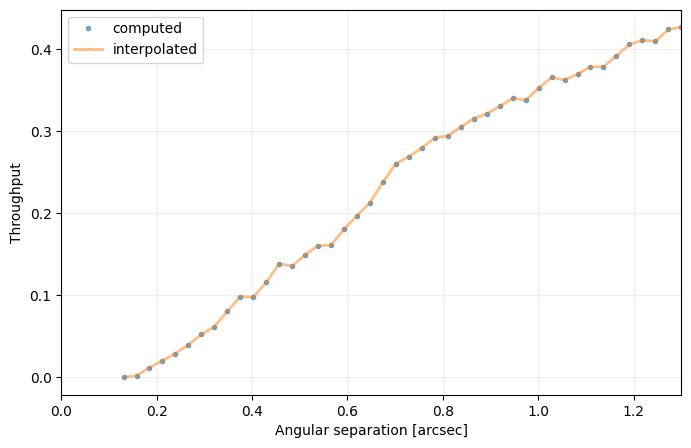

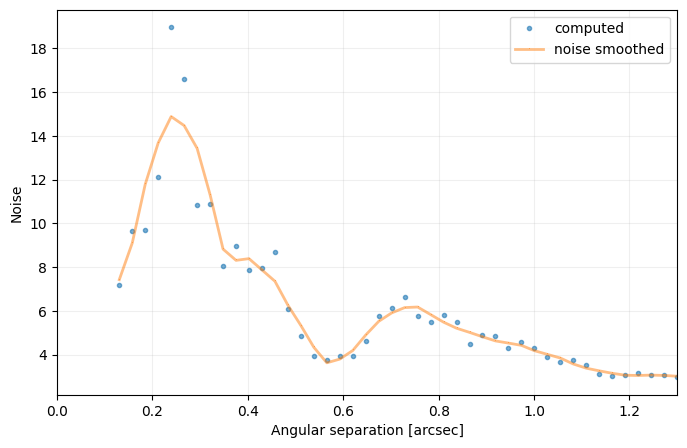

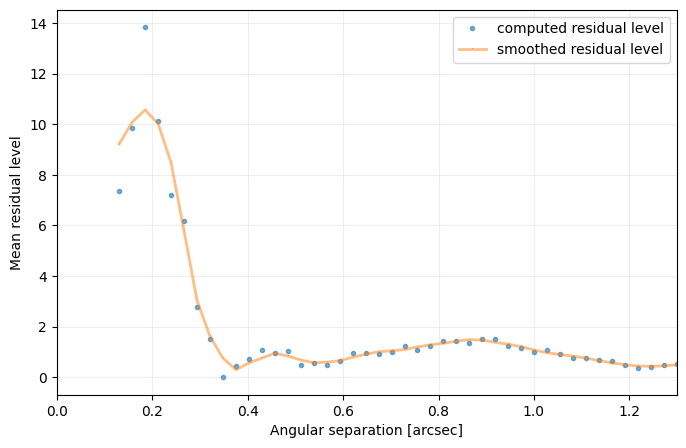

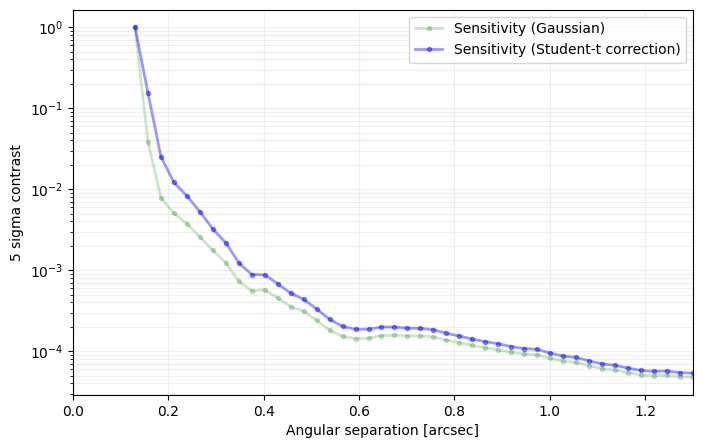

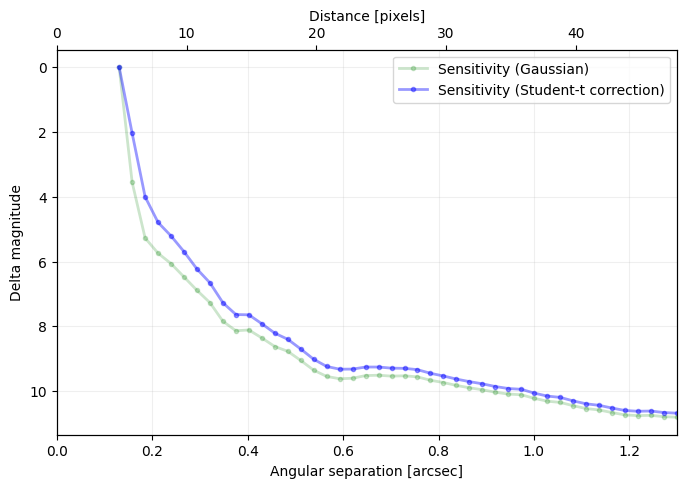

In [35]:
from vip_hci.metrics import contrast_curve
cc_1 = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                      sigma=nsig, nbranch=1, algo=pca, ncomp=9, debug=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca_annular, FWHM = 4.800919383981533, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:24
―――

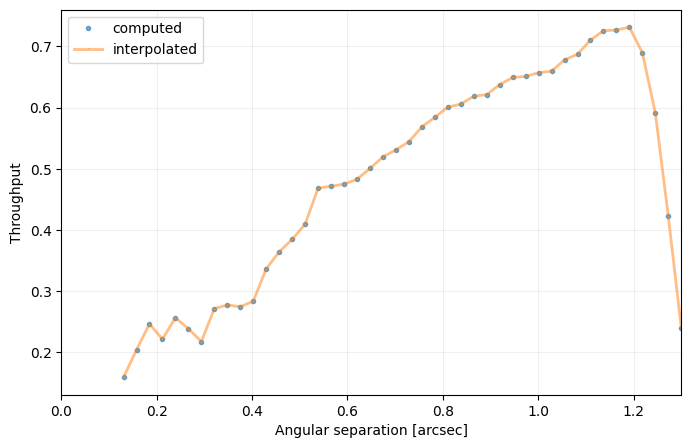

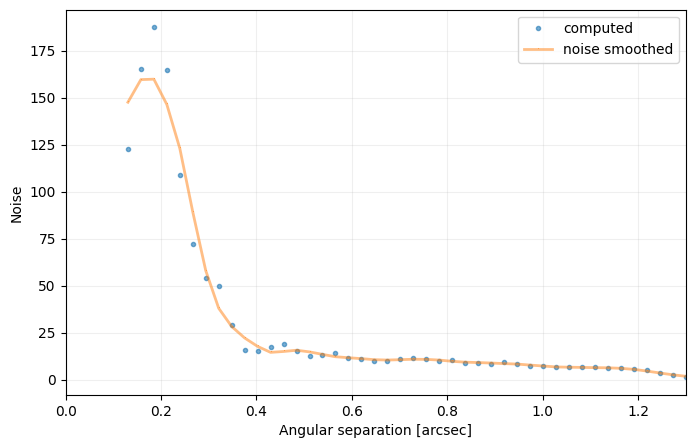

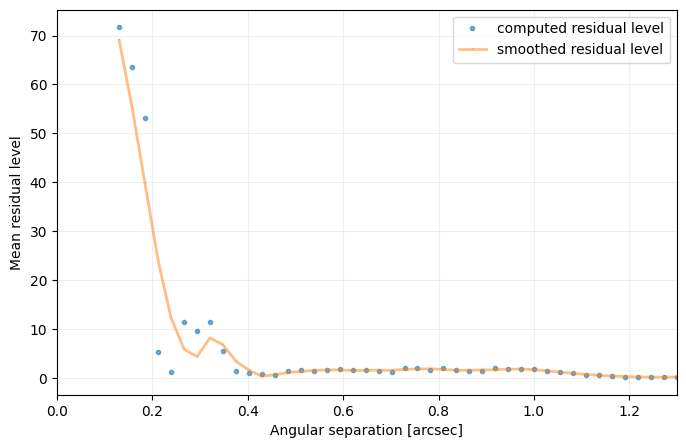

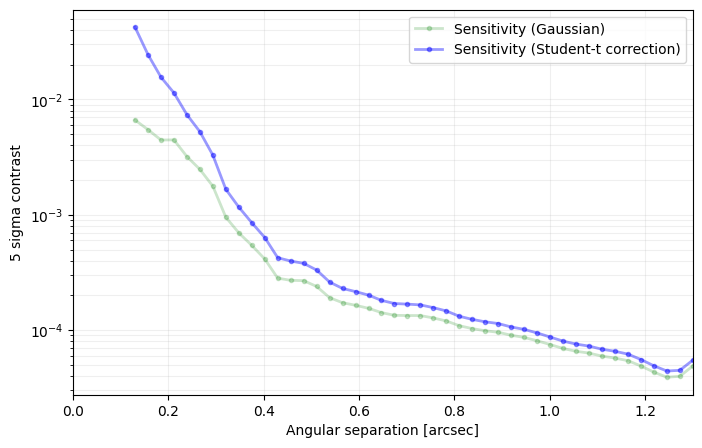

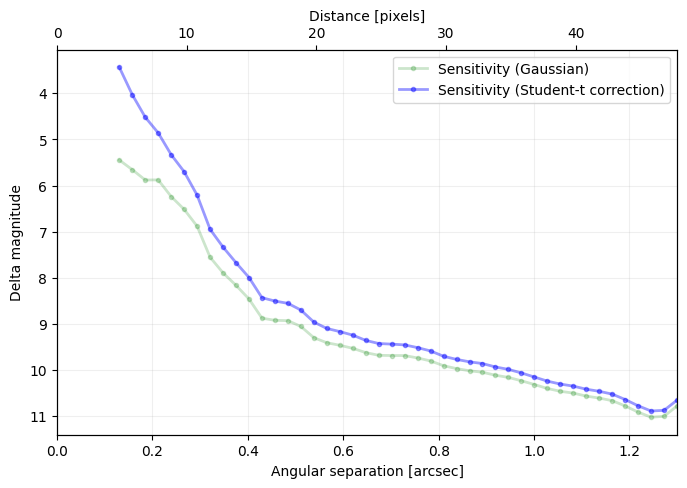

In [36]:
cc_2 = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                      sigma=nsig, nbranch=1, delta_rot=0.5, algo=pca_annular, ncomp=8, 
                      radius_int=int(fwhm_naco), debug=True)

<font color=orange> **Question 4.4**: Considering the hard encoded planet parameters and stellar flux provided above, where would Beta Pic b sit in this contrast curve?</font>

<font color=orange> **Question 4.5**: If a companion is present in the datacube, how do you expect it to affect the contrast curve? In other words what would happen if `cube` was provided to `contrast_curve` instead of `cube_emp`? </font>

<font color=green> **Answer 4.4**:  As illustrated below. </font>

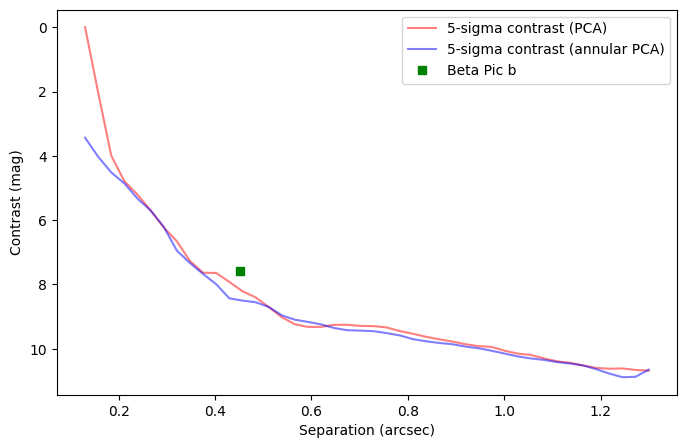

In [37]:
plt.figure(figsize=(8,5))
plt.plot(cc_1['distance']*pxscale_naco, 
         -2.5*np.log10(cc_1['sensitivity_student']), 
         'r-', label='{}-sigma contrast (PCA)'.format(nsig), alpha=0.5)
plt.plot(cc_2['distance']*pxscale_naco, 
         -2.5*np.log10(cc_2['sensitivity_student']), 
         'b-', label='{}-sigma contrast (annular PCA)'.format(nsig), alpha=0.5)
r_b = 16.583
plt.plot(r_b*pxscale_naco, 
         -2.5*np.log10(700./starphot), 'gs', label='Beta Pic b')
plt.gca().invert_yaxis()
plt.ylabel('Contrast (mag)')
plt.xlabel('Separation (arcsec)')
_ = plt.legend(loc='best')
plt.show()

<font color=green> **Answer 4.5**:  It would artificially increase the estimated contrast at the radial separation of the companion (creating a bump in the curve) - as it would be considered as extra noise. Illustration below: </font>

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca_annular, FWHM = 4.800919383981533, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-25 20:57:36
―――

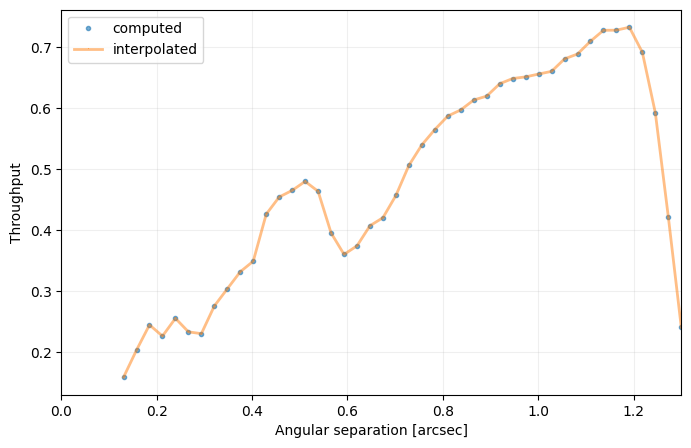

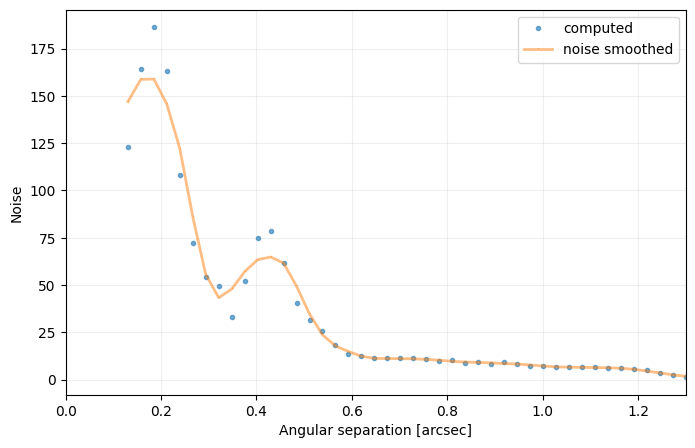

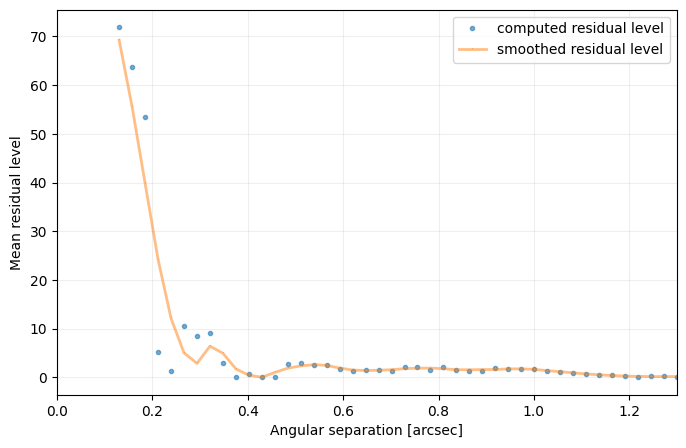

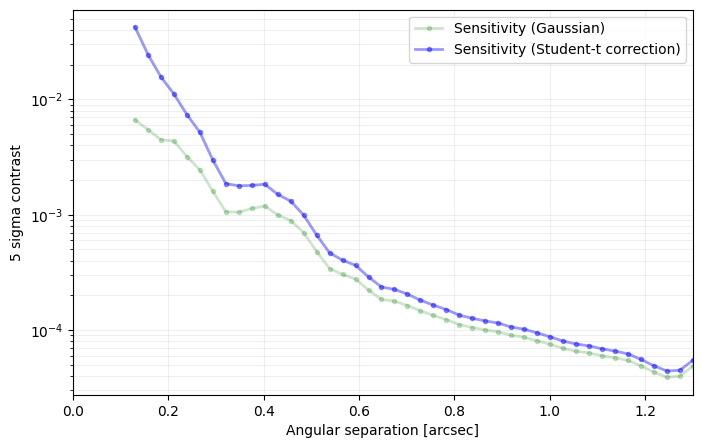

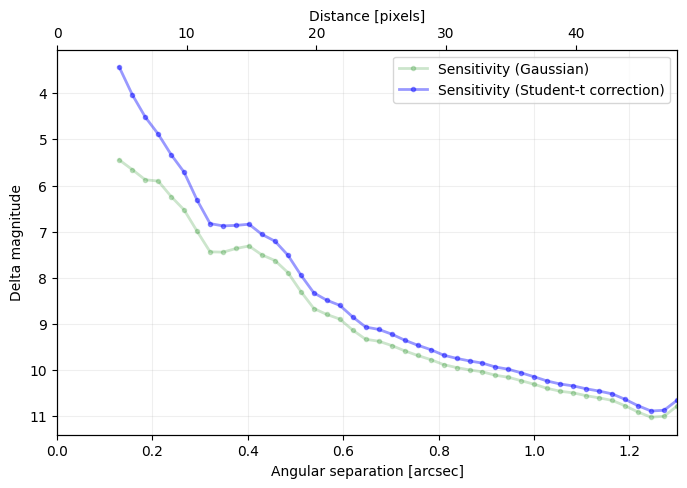

In [38]:
cc_not_emp = contrast_curve(cube, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                            sigma=nsig, nbranch=1, delta_rot=0.5, algo=pca_annular, ncomp=8, 
                            radius_int=int(fwhm_naco), debug=True)

## 4.5. Completeness curves and maps

### 4.5.1. Completeness curves

`VIP` allows the calculation of completeness curves, as implemented in [Dahlqvist et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..49D/abstract) following the framework introduced in [Jensen-Clem et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018AJ....155...32J/abstract).

These are contrast curves corresponding to a given completeness level (e.g. 95%) and one false positive in the full frame. In other words, the 95% completeness curve corresponds to the contrast at which a given companion would be recovered 95% of the time (19/20 true positives).

Setting `an_dist` to None produces a contrast curve spanning 2 FWHM in radius to half 
the size of the provided cube images minus half of the PSF frame, with a step of 5 pixels.

In [39]:
# let's first crop the PSF image
from vip_hci.preproc import frame_crop
crop_sz = 15
if psf.shape[-1]>crop_sz:
    psf = frame_crop(psf, crop_sz)
    

New shape: (15, 15)


Calculating initial SNR map with no injected companion...
*** Calculating contrast at r = 10 ***
Found contrast level for first TP detection: 0.00015000000000000001
Found lower and upper bounds of sought contrast: [0.0017085937499999998, 0.0025628906249999996]
=> found final contrast for 95.0% completeness: 0.0019221679687499997
*** Calculating contrast at r = 15 ***
Found contrast level for first TP detection: 6.666666666666667e-05
Found lower and upper bounds of sought contrast: [0.0003375, 0.00050625]
=> found final contrast for 95.0% completeness: 0.0004364181518554688
*** Calculating contrast at r = 20 ***
Found contrast level for first TP detection: 0.00011250000000000001
Found lower and upper bounds of sought contrast: [0.000253125, 0.0003796875]
=> found final contrast for 95.0% completeness: 0.00029978099999999994
*** Calculating contrast at r = 25 ***
Found contrast level for first TP detection: 4e-05
Found lower and upper bounds of sought contrast: [0.00013500000000000003, 0

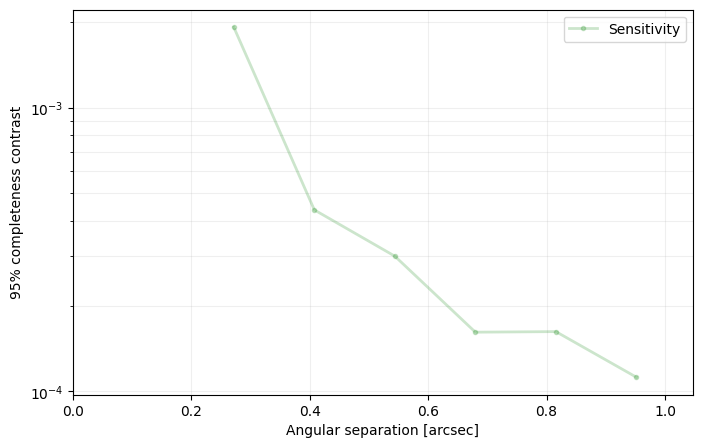

In [40]:
from vip_hci.metrics import completeness_curve
an_dist, comp_curve = completeness_curve(cube_emp, angs, psf, fwhm_naco, pca, an_dist=np.arange(10,40,5), 
                                         pxscale=pxscale_naco, ini_contrast = 1e-3/np.arange(10,40,5), starphot=starphot, 
                                         plot=True, nproc=None, algo_dict={'ncomp':3, 'imlib':'opencv'})

### 4.5.2. Completeness maps

One can also compute completeness maps, considering the dependency of the contrast on both radius and completeness. Since this is a very slow process (even slower than the completeness curve), we will limit it to only one of the radii tested for the completeness curves, and set the initial contrast (`ini_contrast`) to the output of the `completeness_curve` function at that radius: 

In [41]:
n_fc = 20
test_an_dist = 25 # tested radial distance

# initial contrast set to value found in completeness curve
idx = np.where(an_dist == test_an_dist)[0]
ini_contrast = comp_curve[idx]

In [42]:
from vip_hci.metrics import completeness_map
an_dist, comp_levels, contrasts = completeness_map(cube_emp, angs, psf, fwhm_naco, pca, an_dist=[test_an_dist], 
                                                   n_fc=n_fc, ini_contrast=ini_contrast, starphot=starphot, 
                                                   nproc=None, algo_dict={'ncomp':3, 'imlib':'opencv'})

Starting annulus 25
Lower bound (5%) found: 1.2146332441206635e-05
Upper bound (95%) found: 0.00016176843832076777
Data point 0.1 found. Still 14 data point(s) missing
Data point 0.15 found. Still 13 data point(s) missing
Data point 0.25 found. Still 12 data point(s) missing
Data point 0.4 found. Still 10 data point(s) missing
Data point 0.55 found. Still 8 data point(s) missing
Data point 0.6 found. Still 7 data point(s) missing
Data point 0.7 found. Still 5 data point(s) missing
Data point 0.8 found. Still 3 data point(s) missing


Let's plot the achieved contrast as a function of the assumed completeness ratio, at a radial separation of 25 px:

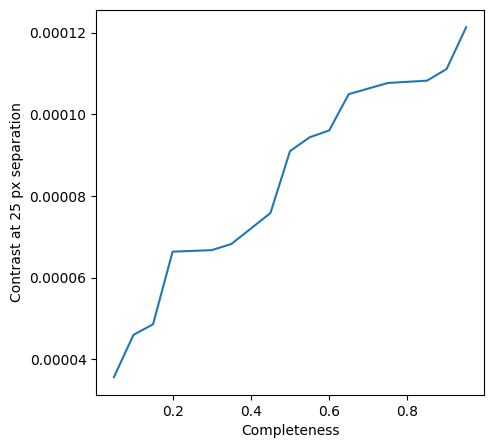

In [43]:
fig = plt.figure(figsize = [5,5])
plt.plot(comp_levels, contrasts[0,:])
plt.xlabel("Completeness")
plt.ylabel("Contrast at {} px separation".format(test_an_dist))
plt.show()

## 4.6. Applefy contrast curves and grids

[Applefy](https://applefy.readthedocs.io/en/latest/index.html#) enables the calculation of robust detection limits, be it contrast curves or contrast grids, for different assumptions on the residual noise in the image (see details in [Bonse et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....166...71B/abstract)). The package is not a mandatory requirement of VIP, but intercompatibility is possible with the `pca` algorithm (only option as of 31 August 2023, more algorithms may become compatible later). Below are some example usages to calculate robust contrast curves and contrast grids if you have Applefy installed (see installation instructions [here](https://applefy.readthedocs.io/en/latest/01_getting_started.html#additional-options)).

In [44]:
try:
    import applefy
    applefy_installed=True
except:
    applefy_installed=False

Let's first define an Applefy Contrast instance for our dataset (using the cube where the planet was already removed), and a checkpoint directory where intermediate files will be saved (also enabling a faster re-calculation of the contrast curves later):

In [ ]:
checkpoint_dir = "../datasets/TMP/cc/"

In [46]:
if applefy_installed:
    from applefy.detections.contrast import Contrast
    contrast_instance = Contrast(science_sequence=cube_emp, psf_template=psf, parang_rad=angs,
                                 psf_fwhm_radius=fwhm_naco/2, dit_psf_template=1., dit_science=starphot,
                                 scaling_factor=1., # A factor to account e.g. for ND filters
                                 checkpoint_dir=checkpoint_dir)

---
**NOTE**

Since the PSF is already normalized to an integrated flux of unity within 1 FWHM, we can just set the ratio between dit_science and dit_psf_template to be the integrated starphot flux. 

---

### 4.6.1. Applefy contrast curves

Let's now define the brightness and number of fake planets to be injected:

In [47]:
flux_ratio_mag = 14  # magnitude difference of injected fake planets
num_fake_planets = 6 # number of injected fake planets azimuthally

In [48]:
if applefy_installed:
    from applefy.utils import flux_ratio2mag, mag2flux_ratio
    flux_ratio = mag2flux_ratio(flux_ratio_mag)
    print("{} fake planets will be injected azimuthally at {} flux ratio ({:.1f} mag difference)".format(num_fake_planets,
                                                                                                      flux_ratio, 
                                                                                                      flux_ratio_mag))

6 fake planets will be injected azimuthally at 2.5118864315095823e-06 flux ratio (14.0 mag difference)


In [49]:
if applefy_installed:
    contrast_instance.design_fake_planet_experiments(flux_ratios=flux_ratio,
                                                     num_planets=num_fake_planets,
                                                     overwrite=True)

Let's now run the fake planet experiment. For this we consider a grid of tested numbers of principal components:

In [50]:
if applefy_installed:
    num_pcas = (1, 41, 8)
    components = list(range(num_pcas[0], num_pcas[1]+num_pcas[2], num_pcas[2]))
    from applefy.wrappers.vip import MultiComponentPCAvip
    algorithm_function = MultiComponentPCAvip(num_pcas=num_pcas, kwarg={'verbose':False})
    contrast_instance.run_fake_planet_experiments(algorithm_function=algorithm_function, 
                                                  num_parallel=cpu_count()//2)

Running fake planet experiments...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [02:32<00:00,  2.50s/it]


[DONE]


Select the aperture photometry mode (choice between spaced pixels "FS" or aperture sums "ASS"):

In [51]:
if applefy_installed:
    from applefy.utils.photometry import AperturePhotometryMode
    # Use apertures pixel values
    photometry_mode_planet = AperturePhotometryMode(
        "ASS", # or "AS"
        psf_fwhm_radius=fwhm_naco/2, 
        search_area=0.5)

    photometry_mode_noise = AperturePhotometryMode(
        "AS",
        psf_fwhm_radius=fwhm_naco/2)

In [52]:
if applefy_installed:
    contrast_instance.prepare_contrast_results(
        photometry_mode_planet=photometry_mode_planet,
        photometry_mode_noise=photometry_mode_noise)

Select the statistical test to be used:

In [53]:
if applefy_installed:
    from applefy.statistics import TTest, gaussian_sigma_2_fpf, fpf_2_gaussian_sigma, LaplaceBootstrapTest

In [54]:
if applefy_installed:
    statistical_test = TTest()

Finally, let's calculate the contrast curves (see all options in the [Applefy tutorial](https://applefy.readthedocs.io/en/latest/02_user_documentation/01_contrast_curves.html))

In [55]:
if applefy_installed:
    contrast_curves, contrast_errors = contrast_instance.compute_analytic_contrast_curves(
        statistical_test=statistical_test,
        confidence_level_fpf=gaussian_sigma_2_fpf(5),
        num_rot_iter=20,
        pixel_scale=0.02718)

Computing contrast curve for PCA (001 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.68it/s]


Computing contrast curve for PCA (009 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.73it/s]


Computing contrast curve for PCA (017 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Computing contrast curve for PCA (025 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.71it/s]


Computing contrast curve for PCA (033 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


Computing contrast curve for PCA (041 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


Let's examine the output:

In [56]:
if applefy_installed:
    contrast_curves

Let's now plot the contrast curves:

In [57]:
if applefy_installed:
    # compute the overall best contrast curve
    overall_best = np.min(contrast_curves.values, axis=1)

In [58]:
if applefy_installed:
    # get the error bars of the the overall best contrast curve
    best_idx = np.argmin(contrast_curves.values, axis=1)
    best_contrast_errors = contrast_errors.values[np.arange(len(best_idx)), best_idx]

In [59]:
if no_sns:
    colors = ['b','c','g','y','orange','r','m','k']
else:
    # nicer plotting if seaborn installed
    colors = sns.color_palette("rocket_r",
                               n_colors=len(contrast_curves.columns))
    colors.append('b')

In [60]:
if applefy_installed:
    separations_arcsec = contrast_curves.reset_index(level=0).index
    separations_FWHM = contrast_curves.reset_index(level=1).index

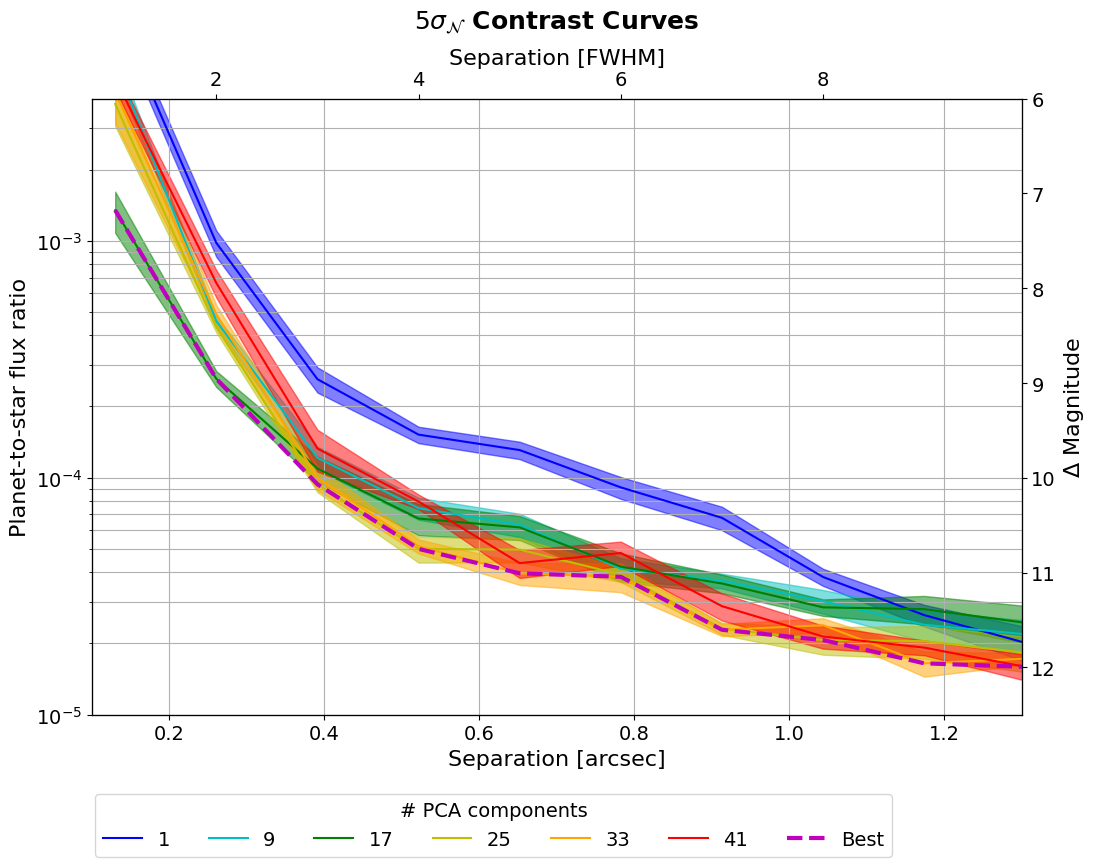

In [61]:
if applefy_installed:
    # 1.) Create Plot Layout
    fig = plt.figure(constrained_layout=False, figsize=(12, 8))
    gs0 = fig.add_gridspec(1, 1)
    axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


    # ---------------------- Create the Plot --------------------
    i = 0 # color picker

    for tmp_model in contrast_curves.columns:

        num_components = int(tmp_model[5:9])
        tmp_flux_ratios = contrast_curves.reset_index(
            level=0)[tmp_model].values
        tmp_errors = contrast_errors.reset_index(
            level=0)[tmp_model].values

        axis_contrast_curvse.plot(
            separations_arcsec,
            tmp_flux_ratios,
            color = colors[i],
            label=num_components)

        axis_contrast_curvse.fill_between(
            separations_arcsec,
            tmp_flux_ratios + tmp_errors, 
            tmp_flux_ratios - tmp_errors,
            color = colors[i],
            alpha=0.5)
        i+=1

    axis_contrast_curvse.set_yscale("log")
    # ------------ Plot the overall best -------------------------
    axis_contrast_curvse.plot(
        separations_arcsec,
        overall_best,
        color = colors[i],
        lw=3,
        ls="--",
        label="Best")

    # ------------- Double axis and limits -----------------------
    lim_mag_y = (12.5, 6)
    lim_arcsec_x = (0.1, 1.3)
    sep_lambda_arcse = interpolate.interp1d(
        separations_arcsec, 
        separations_FWHM, 
        fill_value='extrapolate')

    axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
    axis_contrast_curvse_mag.plot(
        separations_arcsec,
        flux_ratio2mag(tmp_flux_ratios),
        alpha=0.)
    axis_contrast_curvse_mag.invert_yaxis()

    axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
    axis_contrast_curvse_lambda.plot(
        separations_FWHM,
        tmp_flux_ratios,
        alpha=0.)

    axis_contrast_curvse.grid(which='both')
    axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
    axis_contrast_curvse.set_ylim(
        mag2flux_ratio(lim_mag_y[0]), 
        mag2flux_ratio(lim_mag_y[1]))

    axis_contrast_curvse.set_xlim(
        *lim_arcsec_x)
    axis_contrast_curvse_mag.set_xlim(
        *lim_arcsec_x)
    axis_contrast_curvse_lambda.set_xlim(
        *sep_lambda_arcse(lim_arcsec_x))

    # ----------- Labels and fontsizes --------------------------

    axis_contrast_curvse.set_xlabel(
        r"Separation [arcsec]", size=16)
    axis_contrast_curvse_lambda.set_xlabel(
        r"Separation [FWHM]", size=16)

    axis_contrast_curvse.set_ylabel(
        r"Planet-to-star flux ratio", size=16)
    axis_contrast_curvse_mag.set_ylabel(
        r"$\Delta$ Magnitude", size=16)

    axis_contrast_curvse.tick_params(
        axis='both', which='major', labelsize=14)
    axis_contrast_curvse_lambda.tick_params(
        axis='both', which='major', labelsize=14)
    axis_contrast_curvse_mag.tick_params(
        axis='both', which='major', labelsize=14)

    axis_contrast_curvse_mag.set_title(
        r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
        fontsize=18, fontweight="bold", y=1.1)

    # --------------------------- Legend -----------------------
    handles, labels = axis_contrast_curvse.\
        get_legend_handles_labels()

    leg1 = fig.legend(handles, labels, 
                      bbox_to_anchor=(0.12, -0.08), 
                      fontsize=14, 
                      title="# PCA components",
                      loc='lower left', ncol=8)

    _=plt.setp(leg1.get_title(),fontsize=14)

Now let's plot the optimal number of principal components as a function of separation:

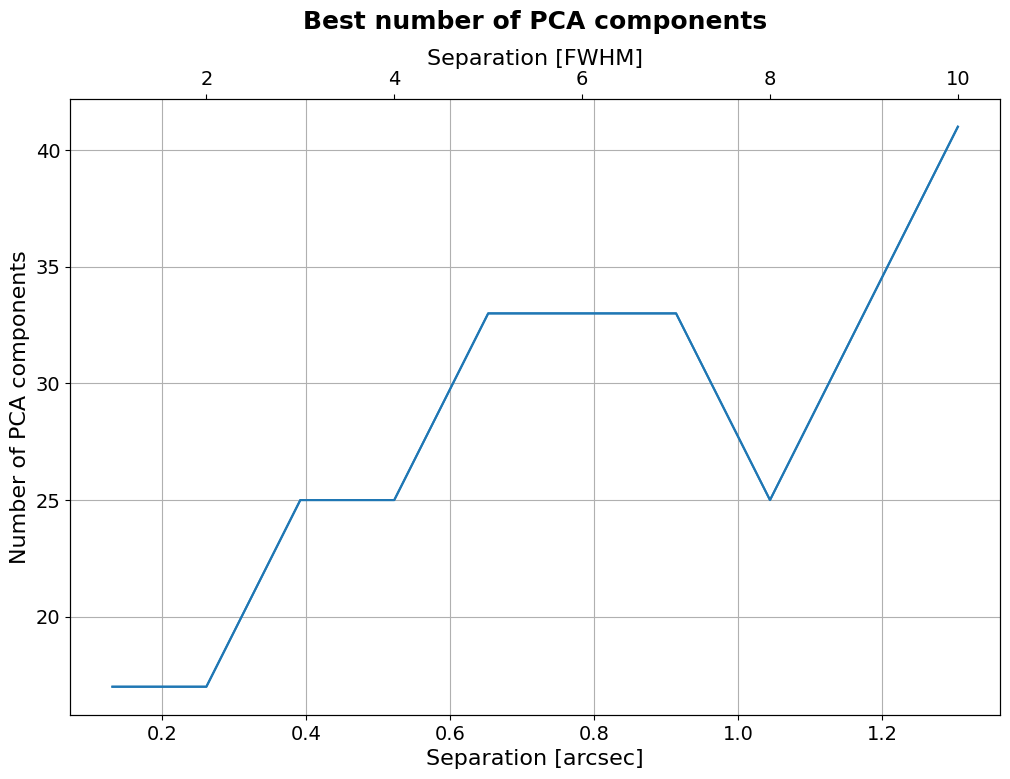

In [62]:
if applefy_installed:
    plt.figure(figsize=(12, 8))

    plt.plot(separations_arcsec, 
             np.array(components)[np.argmin(
                 contrast_curves.values, 
                 axis=1)],)

    plt.title(r"Best number of PCA components",
              fontsize=18, fontweight="bold", y=1.1)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Separation [arcsec]", fontsize=16)
    plt.ylabel("Number of PCA components", fontsize=16)

    plt.grid()
    ax2 = plt.twiny()
    ax2.plot(separations_FWHM, 
             np.array(components)[
                 np.argmin(contrast_curves.values, axis=1)],)
    ax2.set_xlabel("Separation [FWHM]", fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)

### 4.6.2. Applefy contrast grids

Again, let's start by defining a contrast instance, along with a checkpoint directory:

In [ ]:
checkpoint_dir = "../datasets/TMP/cg/"

In [64]:
if applefy_installed:
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    contrast_instance = Contrast(science_sequence=cube_emp, psf_template=psf, parang_rad=angs,
                                 psf_fwhm_radius=fwhm_naco/2, dit_psf_template=1., dit_science=starphot,
                                 scaling_factor=1., # A factor to account e.g. for ND filters
                                 checkpoint_dir=checkpoint_dir)

Let's define the brightness and number of fake planets to be injected - this time we'll consider a range in contrasts:

In [65]:
flux_ratios_mag = np.linspace(7.5, 12, 10)  # magnitude differences of injected fake planets
num_fake_planets = 3 # number of injected fake planets azimuthally

In [66]:
if applefy_installed:
    from applefy.utils import flux_ratio2mag, mag2flux_ratio
    flux_ratios = mag2flux_ratio(flux_ratios_mag)
    print("{} fake planets will be injected azimuthally at {} flux ratios ({} mag difference)".format(num_fake_planets,
                                                                                                      flux_ratios, 
                                                                                                      flux_ratios_mag))

3 fake planets will be injected azimuthally at [1.00000000e-03 6.30957344e-04 3.98107171e-04 2.51188643e-04
 1.58489319e-04 1.00000000e-04 6.30957344e-05 3.98107171e-05
 2.51188643e-05 1.58489319e-05] flux ratios ([ 7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12. ] mag difference)


In [67]:
if applefy_installed:
    contrast_instance.design_fake_planet_experiments(flux_ratios=flux_ratios,
                                                     num_planets=num_fake_planets,
                                                     overwrite=True)

Let's now run the fake planet experiment. For this we consider a grid of tested numbers of principal components:

In [68]:
if applefy_installed:
    num_pcas = (1, 41, 8) # can also be a list of tested values as of VIP v1.5.2 or later, instead of a range
    from applefy.wrappers.vip import MultiComponentPCAvip
    algorithm_function = MultiComponentPCAvip(num_pcas=num_pcas, kwarg={'verbose':False})
    contrast_instance.run_fake_planet_experiments(algorithm_function=algorithm_function, 
                                                  num_parallel=cpu_count()//2)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [13:10<00:00,  2.63s/it]


[DONE]


Select the aperture photometry mode (choice between spaced pixels "FS" or aperture sums "ASS"):

In [69]:
if applefy_installed:
    from applefy.utils.photometry import AperturePhotometryMode
    # Use apertures pixel values
    photometry_mode_planet = AperturePhotometryMode(
        "ASS", # or "AS"
        psf_fwhm_radius=fwhm_naco/2, 
        search_area=0.5)

    photometry_mode_noise = AperturePhotometryMode(
        "AS",
        psf_fwhm_radius=fwhm_naco/2)

In [70]:
if applefy_installed:
    contrast_instance.prepare_contrast_results(
        photometry_mode_planet=photometry_mode_planet,
        photometry_mode_noise=photometry_mode_noise)

Select the statistical test to be used:

In [71]:
if applefy_installed:
    from applefy.statistics import TTest, gaussian_sigma_2_fpf, fpf_2_gaussian_sigma, LaplaceBootstrapTest

In [72]:
if applefy_installed:
    statistical_test = TTest()

Let's then calculate the contrast grids (i.e. the FPF expressed in Gaussian $\sigma$ for different numbers of principal components and different injected contrasts; see all options in the [Applefy tutorial](https://applefy.readthedocs.io/en/latest/02_user_documentation/02_contrast_grid.html))

In [73]:
if applefy_installed:
    contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
        statistical_test=statistical_test,
        num_cores=cpu_count()//2,
        confidence_level_fpf=gaussian_sigma_2_fpf(5),
        num_rot_iter=20,
        safety_margin=1.0,
        pixel_scale=0.02718)

Computing contrast grid for PCA (001 components)
Computing contrast grid with multiprocessing:
....................................................................................................[DONE]
Computing contrast grid for PCA (009 components)
Computing contrast grid with multiprocessing:
....................................................................................................[DONE]
Computing contrast grid for PCA (017 components)
Computing contrast grid with multiprocessing:
....................................................................................................[DONE]
Computing contrast grid for PCA (025 components)
Computing contrast grid with multiprocessing:
....................................................................................................[DONE]
Computing contrast grid for PCA (033 components)
Computing contrast grid with multiprocessing:
.................................................................................................

Two outputs are obtained: **contrast grids** (in the form of a dictionary, one grid for each number of PCs) and **contrast curves** obtained by thresholding the contrast grids (in the form of a Pandas table).

#### 4.6.2.1. Visualizing the contrast grids

In [74]:
if applefy_installed:
    print(contrast_curves_grid)

                                         PCA (001 components)  \
separation [$FWHM$] separation [arcsec]                         
1.0                 0.130489                              inf   
2.0                 0.260978                              inf   
3.0                 0.391467                         0.000242   
4.0                 0.521956                         0.000160   
5.0                 0.652445                         0.000122   
6.0                 0.782934                         0.000085   
7.0                 0.913423                         0.000066   
8.0                 1.043912                         0.000038   
9.0                 1.174401                         0.000024   
10.0                1.304890                         0.000019   

                                         PCA (009 components)  \
separation [$FWHM$] separation [arcsec]                         
1.0                 0.130489                              inf   
2.0                 0.26

Let's check the results for 33 principal components:

In [75]:
ex_pc = 33

In [76]:
if applefy_installed:
    example_grid = contrast_grids["PCA ({:03d} components)".format(ex_pc)]

    # convert FPF to Gaussian Sigma
    example_grid = example_grid.map(fpf_2_gaussian_sigma) 

    # convert flux_ratio to mag
    example_grid.index = flux_ratio2mag(example_grid.index)
    print(example_grid)

separation [FWHM]      1.0       2.0       3.0       4.0        5.0   \
flux_ratio                                                             
7.5                2.252257  5.144352  6.850129  8.698218   9.441878   
8.0                1.985981  4.763529  6.661750  8.456390  10.164601   
8.5                1.634835  4.329917  6.492342  8.479016   9.528872   
9.0                1.634611  3.787807  6.155647  8.352846   9.287306   
9.5                1.400856  3.037851  5.653635  7.745303   8.507686   
10.0               1.055303  2.321637  4.930397  7.018106   7.492572   
10.5               0.849606  1.598340  3.891335  5.715046   6.291197   
11.0               0.768662  1.058462  2.652650  4.291389   4.953590   
11.5               0.712389  0.687179  1.470186  2.845733   3.715718   
12.0               0.652930  0.433480  0.753045  1.749492   2.635426   

separation [FWHM]       6.0        7.0        8.0        9.0        10.0  
flux_ratio                                                  

**_Quick Note_**: The plotting code below relies on `seaborn`, which is not a mandatory dependence of VIP. If you wish to plot the contrast grid result in a nice way, as below, you will need to `pip install seaborn`.

In [77]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):
    
    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")
    
    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7, 
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)
    
    ylabels = ['{:.1f}'.format(float(x.get_text())) 
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text())) 
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

In [78]:
if applefy_installed:
    if not no_sns:
        fig = plt.figure(figsize=(8, 4))

        gs0 = fig.add_gridspec(1, 1)
        gs0.update(wspace=0.0, hspace=0.2)
        gs1 = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec = gs0[0], 
            wspace=0.05, width_ratios=[1, 0.03])

        # All axis we need
        contrast_ax = fig.add_subplot(gs1[0])
        colorbar_ax = fig.add_subplot(gs1[1])

        # Plot the contrast grid
        plot_contrast_grid(
            contrast_grid_axis=contrast_ax,
            colorbar_axis=colorbar_ax,
            contrast_grid=example_grid)

        colorbar_ax.yaxis.label.set_size(14)

        contrast_ax.set_ylabel(
            "Contrast - $c = f_p / f_*$ - [mag]", size=14)
        contrast_ax.set_xlabel(
            r"Separation [FWHM]", size=14)
        contrast_ax.set_title(
            "Contrast Grid with {} PCA components".format(ex_pc), 
            fontsize=16, 
            fontweight="bold", 
            y=1.03)

        contrast_ax.tick_params(
            axis='both', 
            which='major', 
            labelsize=12)

        # Save the figure
        fig.patch.set_facecolor('white')
    else:
        print("To be able to plot the contrast grid results, you will need seaborn installed (e.g. pip install seaborn).")

To be able to plot the contrast grid results, you will need seaborn installed (e.g. pip install seaborn).


#### 4.6.2.2. Visualizing the thresholded contrast curves

In [79]:
if applefy_installed:
    # compute the overall best contrast curve
    overall_best = np.min(contrast_curves_grid.values, axis=1)

In [80]:
# Find one color for each number of PCA components used.
if applefy_installed:
    if no_sns:
        colors = ['b','c','g','y','orange','r','m','k']
    else:
        # nicer plotting if seaborn installed
        colors = sns.color_palette("rocket_r",
                                   n_colors=len(contrast_curves.columns))
        colors

In [81]:
if applefy_installed:
    separations_arcsec = contrast_curves_grid.reset_index(level=0).index
    separations_FWHM = contrast_curves_grid.reset_index(level=1).index

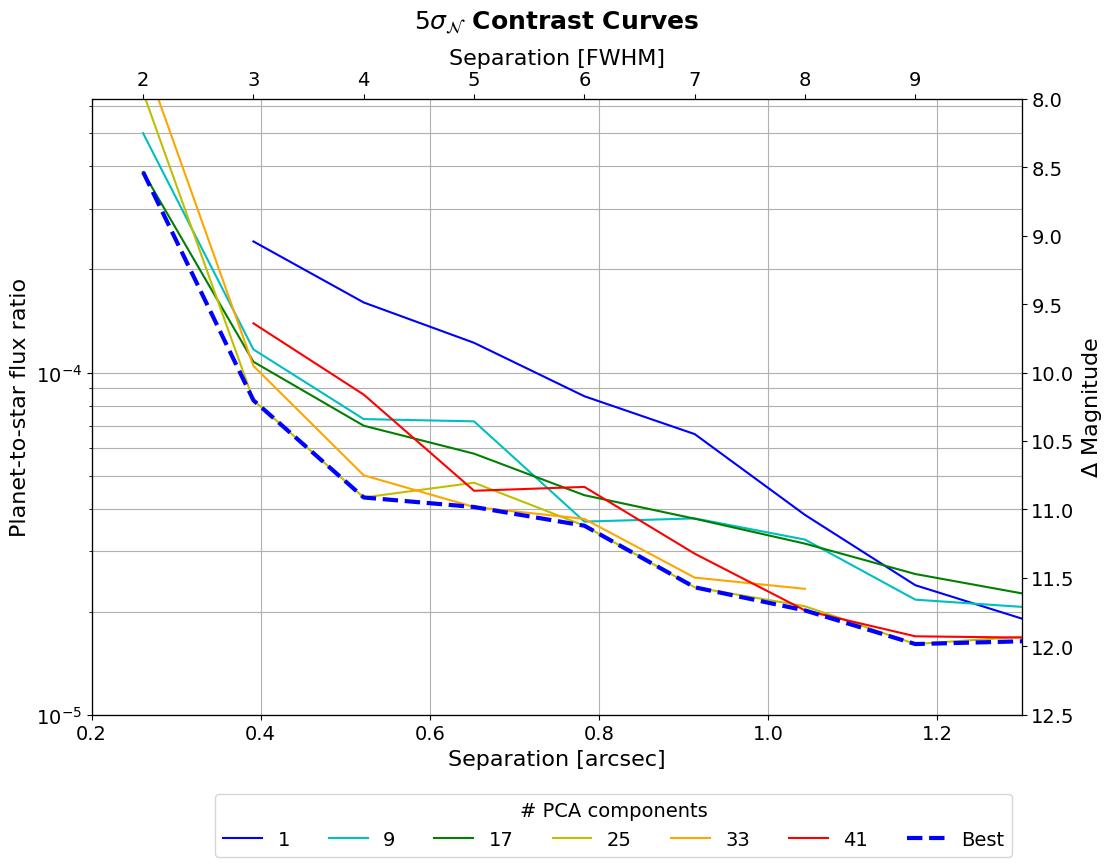

In [82]:
if applefy_installed:
    # 1.) Create Plot Layout
    fig = plt.figure(constrained_layout=False, figsize=(12, 8))
    gs0 = fig.add_gridspec(1, 1)
    axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


    # ---------------------- Create the Plot --------------------
    i = 0 # color picker

    for tmp_model in contrast_curves_grid.columns:

        num_components = int(tmp_model[6:9])
        tmp_flux_ratios = contrast_curves_grid.reset_index(
            level=0)[tmp_model].values

        axis_contrast_curvse.plot(separations_arcsec,
                                  tmp_flux_ratios,
                                  color = colors[i],
                                  label=num_components)
        i+=1

    axis_contrast_curvse.set_yscale("log")
    # ------------ Plot the overall best -------------------------
    axis_contrast_curvse.plot(
        separations_arcsec,
        overall_best,
        color = "blue",
        lw=3,
        ls="--",
        label="Best")

    # ------------- Double axis and limits -----------------------
    lim_mag_y = (12.5, 8)
    lim_arcsec_x = (0.2, 1.3)
    sep_lambda_arcse = interpolate.interp1d(
        separations_arcsec,
        separations_FWHM,
        fill_value='extrapolate')

    axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
    axis_contrast_curvse_mag.plot(
        separations_arcsec,
        flux_ratio2mag(tmp_flux_ratios),
        alpha=0.)
    axis_contrast_curvse_mag.invert_yaxis()

    axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
    axis_contrast_curvse_lambda.plot(
        separations_FWHM,
        tmp_flux_ratios,
        alpha=0.)

    axis_contrast_curvse.grid(which='both')
    axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
    axis_contrast_curvse.set_ylim(
        mag2flux_ratio(lim_mag_y[0]),
        mag2flux_ratio(lim_mag_y[1]))

    axis_contrast_curvse.set_xlim(
        *lim_arcsec_x)
    axis_contrast_curvse_mag.set_xlim(
        *lim_arcsec_x)
    axis_contrast_curvse_lambda.set_xlim(
        *sep_lambda_arcse(lim_arcsec_x))

    # ----------- Labels and fontsizes --------------------------

    axis_contrast_curvse.set_xlabel(
        r"Separation [arcsec]", size=16)
    axis_contrast_curvse_lambda.set_xlabel(
        r"Separation [FWHM]", size=16)

    axis_contrast_curvse.set_ylabel(
        r"Planet-to-star flux ratio", size=16)
    axis_contrast_curvse_mag.set_ylabel(
        r"$\Delta$ Magnitude", size=16)

    axis_contrast_curvse.tick_params(
        axis='both', which='major', labelsize=14)
    axis_contrast_curvse_lambda.tick_params(
        axis='both', which='major', labelsize=14)
    axis_contrast_curvse_mag.tick_params(
        axis='both', which='major', labelsize=14)

    axis_contrast_curvse_mag.set_title(
        r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
        fontsize=18, fontweight="bold", y=1.1)

    # --------------------------- Legend -----------------------
    handles, labels = axis_contrast_curvse.\
        get_legend_handles_labels()

    leg1 = fig.legend(handles, labels,
                      bbox_to_anchor=(0.22, -0.08),
                      fontsize=14,
                      title="# PCA components",
                      loc='lower left', ncol=8)

    _=plt.setp(leg1.get_title(),fontsize=14)

As can be seen, the number of PCs has a clear effect on the achieved contrast.

Let's finally determine the optimal number of principal components as a function of separation. For that, let's first explicitly define components:

In [83]:
if applefy_installed:
    if isinstance(num_pcas, tuple):
        components = list(range(num_pcas[0], num_pcas[1]+num_pcas[2], num_pcas[2]))
    else:
        components = num_pcas

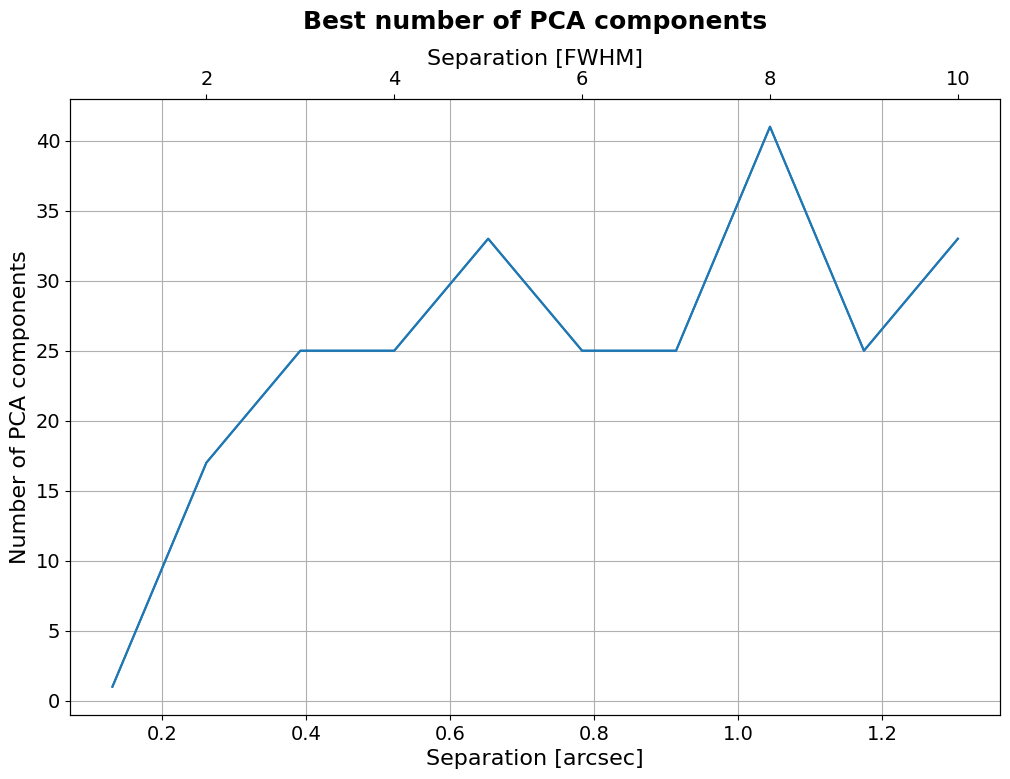

In [84]:
if applefy_installed:
    plt.figure(figsize=(12, 8))

    plt.plot(separations_arcsec,
             np.array(components)[np.argmin(
                 contrast_curves_grid.values,
                 axis=1)],)

    plt.title(r"Best number of PCA components",
              fontsize=18, fontweight="bold", y=1.1)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Separation [arcsec]", fontsize=16)
    plt.ylabel("Number of PCA components", fontsize=16)

    plt.grid()
    ax2 = plt.twiny()
    ax2.plot(separations_FWHM,
             np.array(components)[
                 np.argmin(contrast_curves_grid.values, axis=1)],)
    ax2.set_xlabel("Separation [FWHM]", fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)